In [1]:
%cd ../

/home/ruslan/Documents/course-project-TiMP


In [2]:
import pickle
import matplotlib.pyplot as plt
from collections import Counter, OrderedDict
from sortedcontainers import SortedDict
import numpy as np
import seaborn as sns; sns.set()
from  matplotlib import cm

# Часть 1. code2vec
## Создаём гистограмму для колчества функций встречающихся в датасете в зависимости от их частоты.
Огромная функция для построения графика зависимости количества элементов с данной частотой вхождений от этой частоты.

Происходит парсинг вокабов, полученных при препроцессинге, создание гистограммы, а также вычисление размеров отфильтрованных данных для последующего вывода на график.


In [3]:
def historgram(train_vocab, train_name, test_vocab, test_name, val_vocab, val_name, limit, plot_xlim = 100):
    plt.figure(figsize=(20, 10))
    train_vocab = {key:int(value) for key, value in train_vocab.items()}
    train = SortedDict(sorted(Counter(train_vocab.values()).items()))
    test_vocab = {key:int(value) for key, value in test_vocab.items()}
    test = SortedDict(sorted(Counter(test_vocab.values()).items()))
    val_vocab = {key:int(value) for key, value in val_vocab.items()}
    val = SortedDict(sorted(Counter(val_vocab.values()).items()))
    combined_keys = {*train.keys(), *test.keys(), *val.keys()}
    train_missing_keys = combined_keys - train.keys()
    train.update({key:0 for key in train_missing_keys})
    test_missing_keys = combined_keys - test.keys()
    test.update({key:0 for key in test_missing_keys})
    val_missing_keys = combined_keys - val.keys()
    val.update({key:0 for key in val_missing_keys})
    
    bad = {key:train[key]+test[key]+val[key] for key in train.keys() if key < limit}
    plt.bar(list(train.keys()), list(train.values()), label=train_name)
    plt.bar(list(test.keys()), list(test.values()), bottom=list(train.values()), color='green', label=test_name)
    plt.bar(list(val.keys()), list(val.values()), bottom=np.sum((list(train.values()), list(test.values())), axis=0), color='red', label=val_name)
    plt.bar(list(bad.keys()), list(bad.values()), color="black", label="filtered", alpha=0.4)
    plt.yscale("log")
    plt.legend()
    plt.xlim(0, plot_xlim)
    plt.xlabel("Частота вхождения элемента в AST.")
    plt.ylabel("Количество элементов с такой частотой.")
    bad_quantity = [0,0,0]
    total_quantity = [0, 0, 0]
    for i in range(1, limit):
        bad_quantity[0]+=i*train[i]
        bad_quantity[1]+=i*test[i]
        bad_quantity[2]+=i*val[i]
    for key in train.keys():
        total_quantity[0]+=key*train[key]
        total_quantity[1]+=key*test[key]
        total_quantity[2]+=key*val[key]
    if limit>1:
        plt.title("График для ограничения "+ str(limit))
        plt.suptitle("Для тренировочного датасета: отфильтровано " + str(bad_quantity[0]) + " из " + str(total_quantity[0]) + 
                     ", т. е. "  + "%.2f" % (100 * bad_quantity[0]/total_quantity[0]) + "%.\n"
                     "Для тестового датасета: отфильтровано " + str(bad_quantity[1]) + " из " + str(total_quantity[1]) + 
                     ", т. е. "  + "%.2f" % (100 * bad_quantity[1]/total_quantity[1]) + "%.\n"
                     "Для валидационного датасета: отфильтровано " + str(bad_quantity[2]) + " из " + str(total_quantity[2]) + 
                     ", т. е. "  + "%.2f" % (100 * bad_quantity[2]/total_quantity[2]) + "%.\n"
                    )
    plt.savefig("img.png", dpi=300)

    

Поднимаем данные при помощи pickle, причём первые два словаря в c2v.dict это train_token и train_path, они нам не нужны. После этого загружаем всё в гистограмму.

In [4]:
def dict_info(path, plot_xlim = 100):
    with open(path, "rb") as file:
        _ = pickle.load(file)
        _ = pickle.load(file)
        train = pickle.load(file)
        test = pickle.load(file)
        val = pickle.load(file)
    print("Train", "total:", len(train), "total lines")
    print("Validate", "total:", len(test), "total lines")
    print("Test", "total:", len(val), "total lines")

    historgram(train, "train", test, "test",  val, "validate", int(input()), plot_xlim)


Train total: 197848 total lines
Validate total: 23002 total lines
Test total: 7484 total lines
10


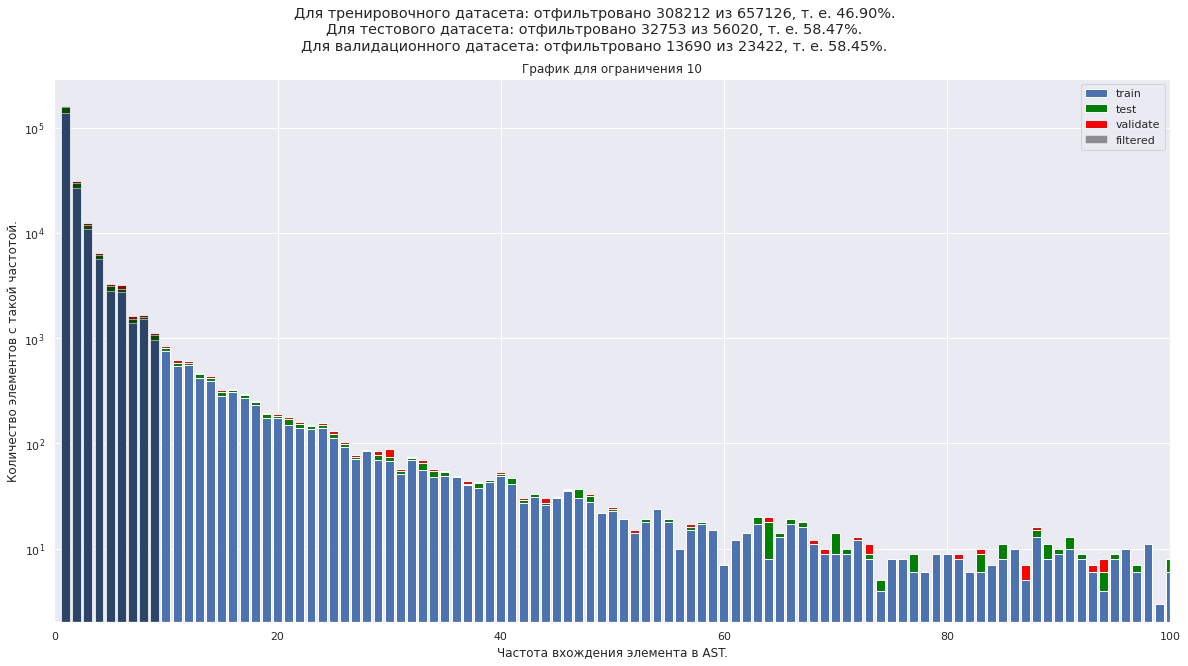

In [5]:
# !./preprocess_existing_dataset.sh 0
dict_info("dataset/java-small/java-small.c2v.dict")

# Гистограмма топ N имён функций по встречаемости из всех наборов.

In [6]:
TRAIN_VOCAB_PATH = "dataset/java-small/java-small.train.functions.vocab"
TEST_VOCAB_PATH = "dataset/java-small/java-small.test.functions.vocab"
VALIDATION_VOCAB_PATH = "dataset/java-small/java-small.validation.functions.vocab"

Загрузим все vocab-ы в pandas-таблицы:

In [7]:
import pandas as pd

train_df = pd.read_csv(TRAIN_VOCAB_PATH, sep=' ', names=["Function", "Frequency"])
test_df = pd.read_csv(TEST_VOCAB_PATH, sep=' ', names=["Function", "Frequency"])
validation_df = pd.read_csv(VALIDATION_VOCAB_PATH, sep=' ', names=["Function", "Frequency"])

train_df["Dataset"] = ["train"] * len(train_df)
test_df["Dataset"] = ["test"] * len(test_df)
validation_df["Dataset"] = ["validation"] * len(validation_df)

display(train_df.sort_values(by="Function"))
display(test_df.sort_values(by="Function"))
display(validation_df.sort_values(by="Function"))

,Function,Frequency,Dataset
52,$,1,train
86721,$$|hibernate|get|entity|entry,2,train
102541,$$|hibernate|get|entity|instance,2,train
87041,$$|hibernate|get|next|managed|entity,2,train
12391,$$|hibernate|get|previous|managed|entity,2,train
...,...,...,...
95362,zz|unpack|attribute,38,train
180564,zz|unpack|c|map,19,train
88738,zz|unpack|row|map,38,train
54670,zz|unpack|trans,38,train


,Function,Frequency,Dataset
103,$,5,test
285,_,67,test
288,a,162,test
13975,abandon|block,4,test
10316,abbr,127,test
...,...,...,...
15763,x|attrs|to|json,1,test
15407,x|attr|names|to|json,1,test
11619,yield,1,test
18973,zip|dir,1,test


,Function,Frequency,Dataset
94,aabb|expand,1,validation
2051,aabb|overlap,1,validation
545,aabb|test,1,validation
5611,able|to|draw,1,validation
6019,abs,5,validation
...,...,...,...
105,y,1,validation
7123,y|slider|moved,4,validation
107,z,1,validation
2081,zero,1,validation


Сгруппируем по дубликатам и просуммируем:

In [8]:
conc = pd.concat([train_df, test_df, validation_df], ignore_index=True)
conc = conc.groupby('Function').sum().reset_index()

display(conc)

,Function,Frequency
0,$,6
1,$$|hibernate|get|entity|entry,2
2,$$|hibernate|get|entity|instance,2
3,$$|hibernate|get|next|managed|entity,2
4,$$|hibernate|get|previous|managed|entity,2
...,...,...
223586,zz|unpack|action,38
223587,zz|unpack|attribute,38
223588,zz|unpack|c|map,19
223589,zz|unpack|row|map,38


Построим гистограмму встречаемости слов для заданного датасета


In [9]:
def target_histogram(data, name, data_type, limit = 50):
    cnt = Counter()
    freqs = data["Frequency"]
    targets = data["Function"]
    for seq, freq in zip(targets, freqs):
        cnt.update({seq: freq})

    srt = sorted(cnt.items(), key=lambda x: x[1], reverse=True)
    srt_labels, srt_freqs = list(map(list, zip(*srt)))
    srt_labels = srt_labels[:limit] + ['other words']
    srt_freqs = srt_freqs[:limit] + [sum(srt_freqs[limit:])]
    plt.figure(figsize=(15, 8))
    plt.title(f"Распределение первых {limit} {data_type} по встречаемости в " + name + " датасете")
    plt.yscale("log")
    plt.xticks(rotation='vertical')
    plt.margins(0.025)
    plt.bar(srt_labels, srt_freqs)
    plt.plot();

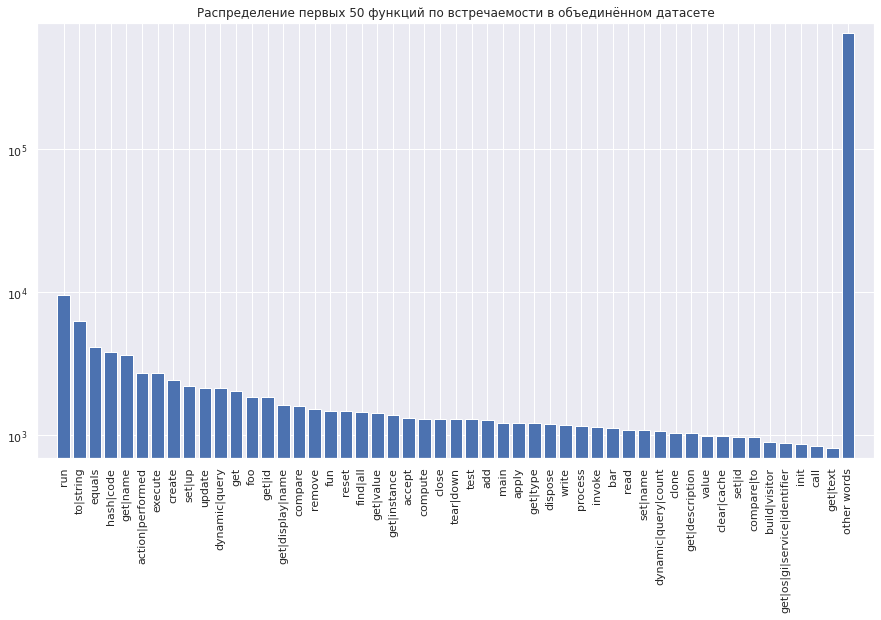

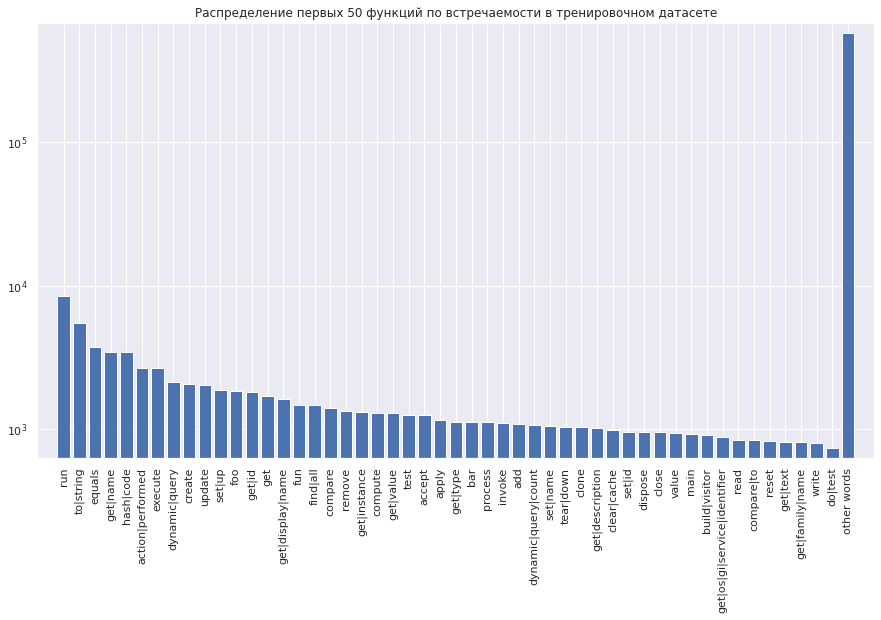

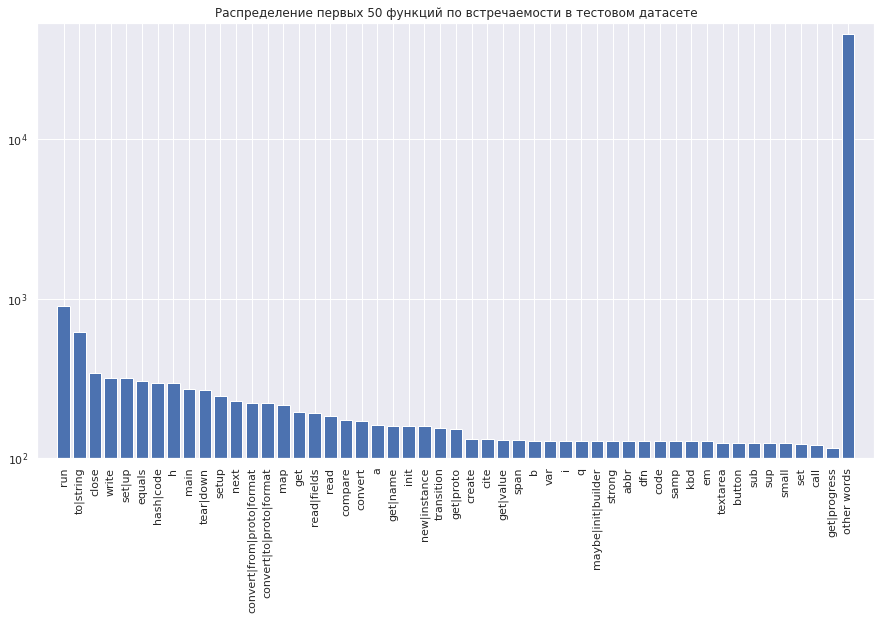

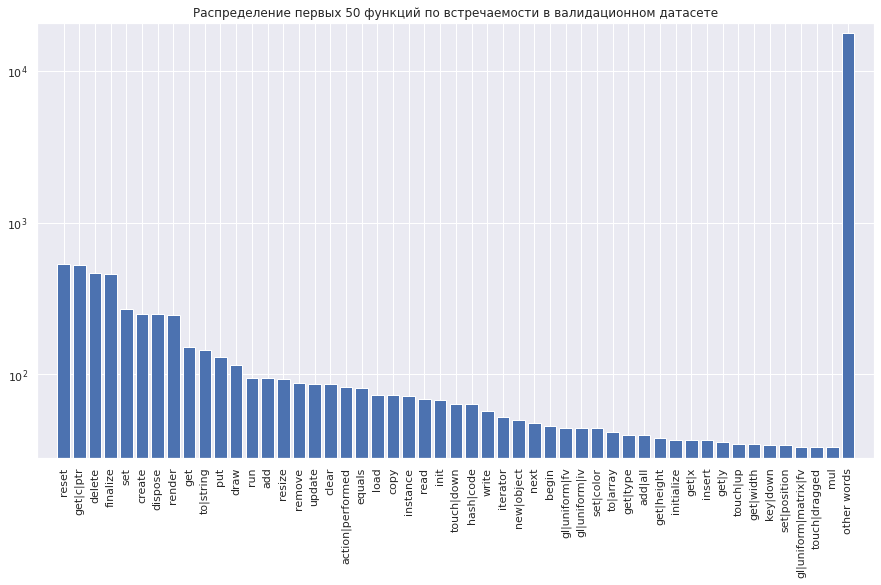

In [10]:
target_histogram(conc, "объединённом", "функций")
target_histogram(train_df, "тренировочном", "функций")
target_histogram(test_df, "тестовом", "функций")
target_histogram(validation_df, "валидационном", "функций")

# Часть 2. code2var

Train total: 116150 total lines
Validate total: 18909 total lines
Test total: 5585 total lines
10


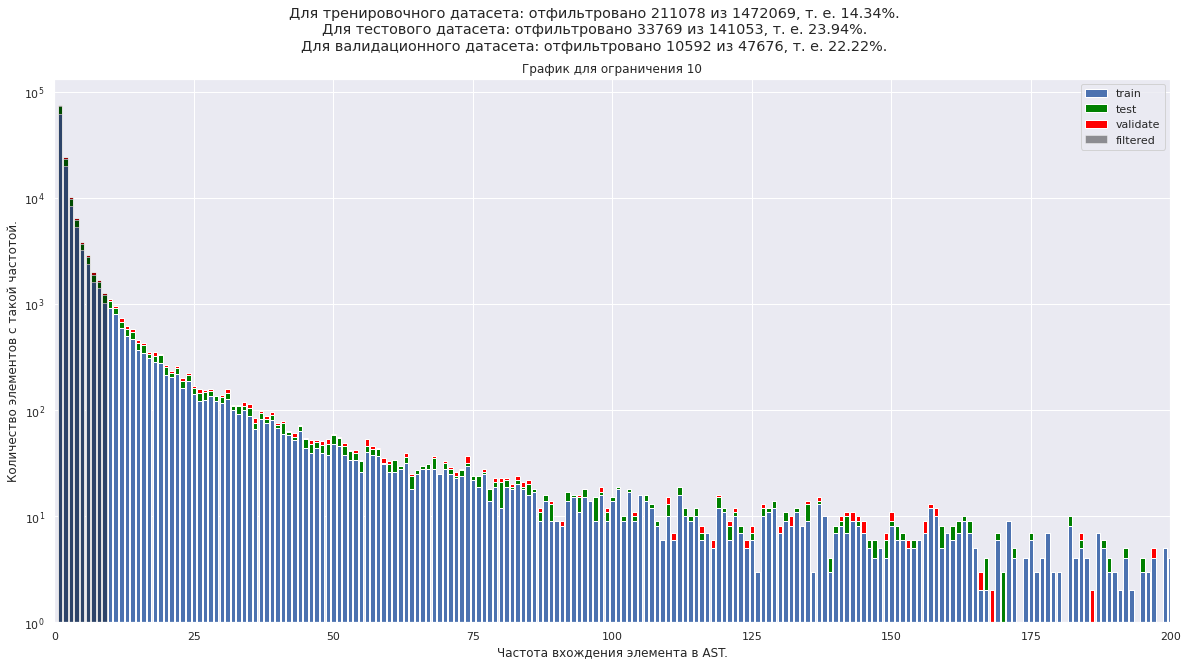

In [11]:
# !./preprocess_existing_dataset.sh 0
dict_info("dataset/java-small/java-small.var.c2v.dict", 200)

# Гистограмма топ N имён функций по встречаемости из всех наборов.

In [12]:
TRAIN_VOCAB_PATH = "dataset/java-small/java-small.train.variables.vocab"
TEST_VOCAB_PATH = "dataset/java-small/java-small.test.variables.vocab"
VALIDATION_VOCAB_PATH = "dataset/java-small/java-small.validation.variables.vocab"

Загрузим все vocab-ы в pandas-таблицы:

In [13]:
import pandas as pd

train_df = pd.read_csv(TRAIN_VOCAB_PATH, sep=' ', names=["Variable", "Frequency"])
test_df = pd.read_csv(TEST_VOCAB_PATH, sep=' ', names=["Variable", "Frequency"])
validation_df = pd.read_csv(VALIDATION_VOCAB_PATH, sep=' ', names=["Variable", "Frequency"])

train_df["Dataset"] = ["train"] * len(train_df)
test_df["Dataset"] = ["test"] * len(test_df)
validation_df["Dataset"] = ["validation"] * len(validation_df)

train_df["Variable"].astype(str)
test_df["Variable"].astype(str)
validation_df["Variable"].astype(str)

display(train_df.sort_values(by="Variable"))
display(test_df.sort_values(by="Variable"))
display(validation_df.sort_values(by="Variable"))
display(train_df.dtypes)

,Variable,Frequency,Dataset
64,$,1,train
170,_,2,train
16987,_1,1,train
16992,_2,1,train
176,a,2266,train
...,...,...,...
87473,zz|row|map|l,19,train
38213,zz|trans|l,19,train
24360,z|id,1,train
56678,z|score,1,train


,Variable,Frequency,Dataset
248,_,2,test
257,a,236,test
15893,aa,3,test
14779,aai,1,test
16855,aaid,4,test
...,...,...,...
1468,zs,2,test
1469,zt,2,test
9351,zvec,3,test
1486,zz,4,test


,Variable,Frequency,Dataset
91,a,329,validation
4340,aab,1,validation
4577,aabb,28,validation
3171,aabbi,1,validation
3172,aabbj,1,validation
...,...,...,...
2505,z|divisions,1,validation
5048,z|far,6,validation
538,z|near,6,validation
1696,z|orth,1,validation


Variable     object
Frequency     int64
Dataset      object
dtype: object

Сгруппируем по дубликатам и просуммируем:

In [14]:
conc = pd.concat([train_df, test_df, validation_df], ignore_index=True)
conc = conc.groupby('Variable').sum().reset_index()

display(conc)

,Variable,Frequency
0,$,1
1,_,4
2,_1,1
3,_2,1
4,a,2831
...,...,...
133982,z|near,6
133983,z|orth,1
133984,z|pend,1
133985,z|score,1


Построим гистограмму встречаемости слов для заданного датасета


In [15]:
def target_histogram_var(data, name, limit = 50):
    cnt = Counter()
    freqs = data["Frequency"]
    targets = data["Variable"]
    for seq, freq in zip(targets, freqs):
        cnt.update({seq: freq})

    srt = sorted(cnt.items(), key=lambda x: x[1], reverse=True)
    srt_labels, srt_freqs = list(map(list, zip(*srt)))
    srt_labels = np.array(srt_labels[:limit] + ['other words'], dtype=np.str)
    srt_freqs = srt_freqs[:limit] + [sum(srt_freqs[limit:])]
    plt.figure(figsize=(15, 8))
    plt.title(f"Распределение первых {limit} переменных по встречаемости в " + name + " датасете")
    plt.yscale("log")
    plt.xticks(rotation='vertical')
    plt.margins(0.025)
    plt.bar(srt_labels, srt_freqs)
    plt.plot();

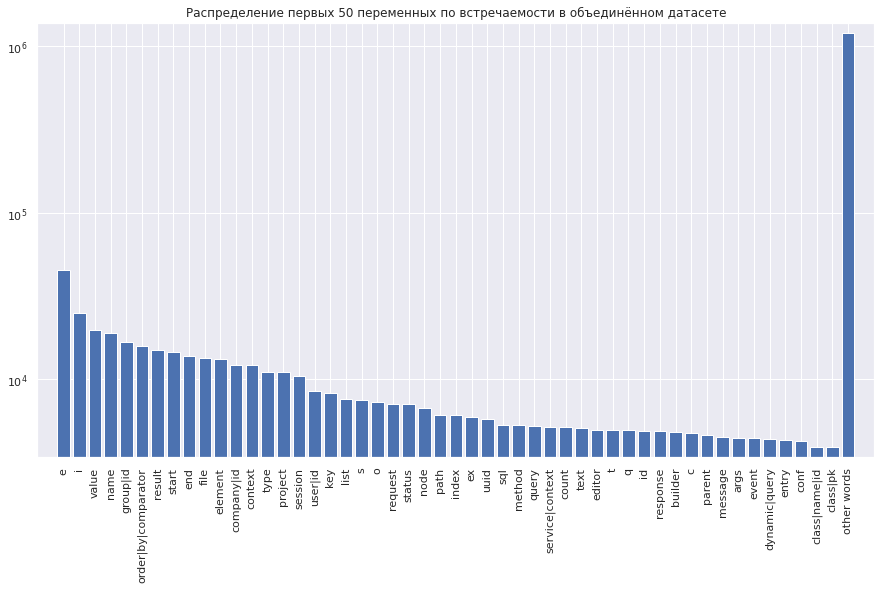

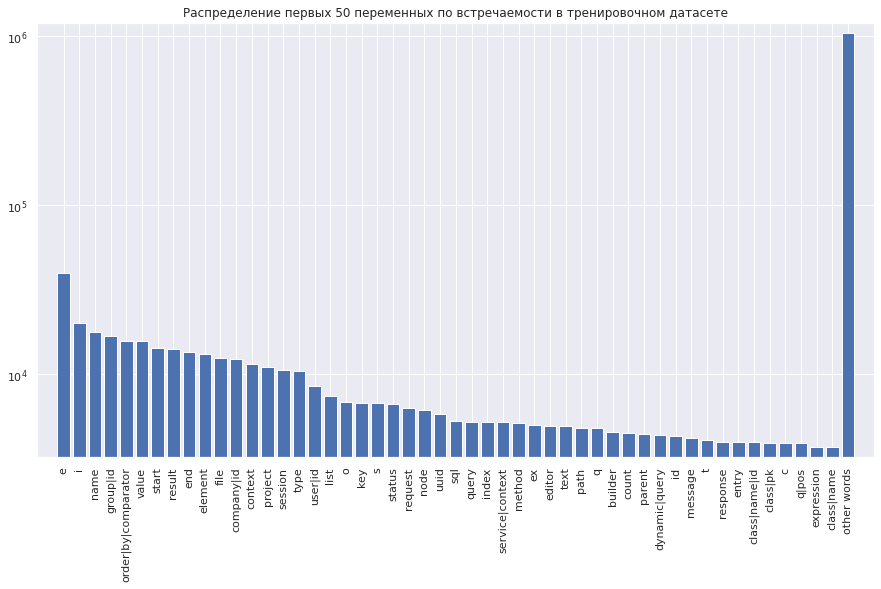

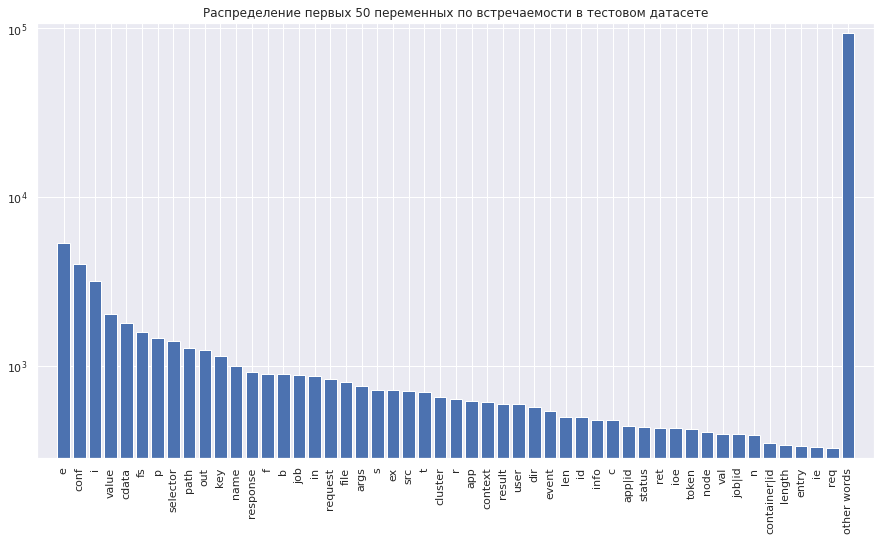

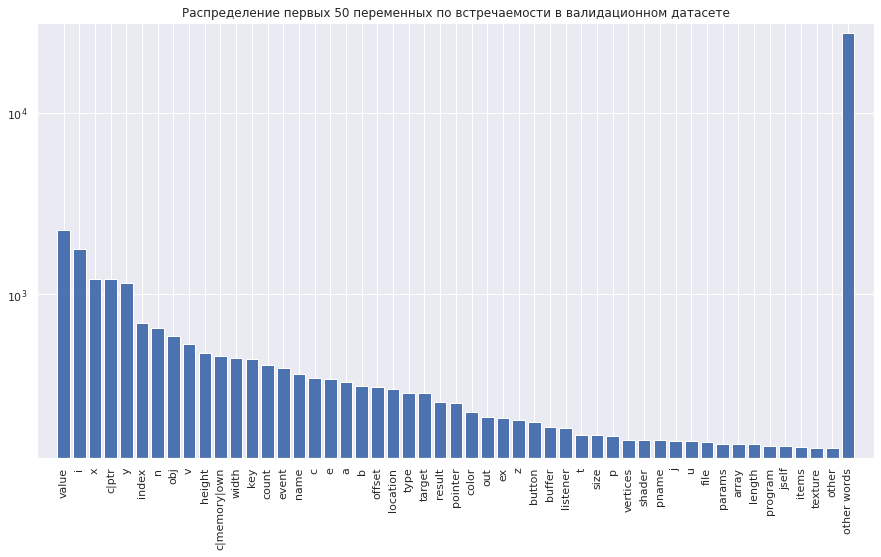

In [16]:
target_histogram_var(conc, "объединённом")
target_histogram_var(train_df, "тренировочном")
target_histogram_var(test_df, "тестовом")
target_histogram_var(validation_df, "валидационном")